In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Apply Deep Learning to predict delay classes

In [2]:
## Training with weather data

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import holidays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from scipy.stats import  randint
from scipy.stats import uniform
import math
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'keras'

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Build X_train

In [4]:
df_train = pd.read_csv('fl_wea_train.csv')

Text(0.5, 1.0, 'Distribution of delay in minutes')

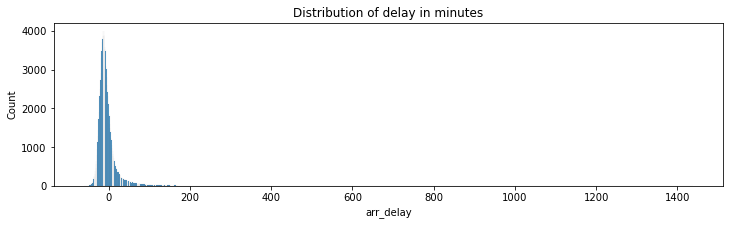

In [7]:
plt.figure(figsize=(12,3))
sns.histplot(df_train['arr_delay'])
plt.title('Distribution of delay in minutes')

In [5]:
col = df_train.columns.tolist()

In [9]:
col = ['fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
 'crs_dep_time',  'crs_arr_time', 'arr_delay',  'distance',     
 'tmpf', 'sknt', 'vsby', 'gust', 'skyl1', 'ice_accretion_3hr',
 'tmpf_arr', 'sknt_arr', 'vsby_arr', 'gust_arr', 'skyl1_arr', 'ice_accretion_3hr_arr']

In [10]:
X_train = df_train[col]

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117640 entries, 0 to 117639
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fl_date                117640 non-null  object 
 1   op_unique_carrier      117640 non-null  object 
 2   op_carrier_fl_num      117640 non-null  int64  
 3   origin_airport_id      117640 non-null  int64  
 4   dest_airport_id        117640 non-null  int64  
 5   crs_dep_time           117640 non-null  int64  
 6   crs_arr_time           117640 non-null  int64  
 7   arr_delay              116887 non-null  float64
 8   distance               117640 non-null  float64
 9   tmpf                   117640 non-null  float64
 10  sknt                   117640 non-null  float64
 11  vsby                   117640 non-null  float64
 12  gust                   117640 non-null  float64
 13  skyl1                  117640 non-null  float64
 14  ice_accretion_3hr      117640 non-nu

In [12]:
# after test data, arr_delay should be 0. 
X_train['arr_delay'].fillna(0,inplace=True)

#remove outliner
X_train = X_train[(X_train['arr_delay'] > -80) & (X_train['arr_delay'] <= 480)] 

#combine features
def combine_str_num(x,y):
    return x + str(y)
X_train['uni_fl'] = np.vectorize(combine_str_num)(X_train['op_unique_carrier'],X_train['op_carrier_fl_num'])
X_train.drop(columns=['op_unique_carrier','op_carrier_fl_num'],inplace=True)

# target encoding -- flight numbers
total_target_mean = np.mean(X_train['arr_delay'])
unifl_target_mean = X_train.groupby(['uni_fl'])['arr_delay'].mean()
X_train['uni_fl'] =X_train['uni_fl'].map(unifl_target_mean)



# target encoding -- flight numbers
total_target_mean = np.mean(X_train['arr_delay'])
unifl_target_mean = X_train.groupby(['uni_fl'])['arr_delay'].mean()
X_train['uni_fl'] =X_train['uni_fl'].map(unifl_target_mean)

# target  encoding -- airport in detail hour
dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_train['dep_airport_hour'] =X_train['dep_airport_hour'].map(dep_hour_target_mean)
arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_train['arr_airport_hour'] =X_train['arr_airport_hour'].map(arr_hour_target_mean)

In [15]:
## Combine the airportid and related hour
## Combine the airportid and related hour
def airport_hour(id,t):
    '''
    combine airport and hour to a new field
    '''
    t = t // 100
    if t == 24:
        t = 0
    l = '0' + str(t)
    return str(id) + l[-2:]
    
X_train['arr_airport_hour'] = np.vectorize(airport_hour)(X_train['dest_airport_id'],X_train['crs_arr_time'])
X_train['dep_airport_hour'] = np.vectorize(airport_hour)(X_train['origin_airport_id'],X_train['crs_dep_time'])

# feature coding
dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_train['dep_airport_hour'] =X_train['dep_airport_hour'].map(dep_hour_target_mean)
arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_train['arr_airport_hour'] =X_train['arr_airport_hour'].map(arr_hour_target_mean)

X_train.drop(columns=['dest_airport_id','crs_arr_time','origin_airport_id','crs_dep_time'],inplace=True)

In [16]:
pi=3.14159
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

#transform fl_date
#def getmonth(x):
#    return x.split(sep='-')[1]
#X_train['month'] = X_train['fl_date'].apply(getmonth)

#sin_m, cos_m = transformation(X_train['month'].astype('int32'))
#X_train['mon_sin'] = sin_m
#X_train['mon_cos'] = cos_m


def getdayofweek(x):
    year_s, mon_s, day_s = x.split('-')
    fl_d = datetime(int(year_s), int(mon_s), int(day_s))
    return fl_d.weekday() + 1
X_train['day_of_week'] = X_train['fl_date'].apply(getdayofweek)

us_holidays = holidays.UnitedStates()
def isholiday(x):
    year_s, mon_s, day_s = x.split('-')
    if datetime(int(year_s), int(mon_s), int(day_s)) in us_holidays:
        return 1
    else:
        return 0
X_train['is_holiday'] = X_train['fl_date'].apply(isholiday)



sin_l, cos_l = transformation(X_train['day_of_week'])

X_train['dow_sin'] = sin_l
X_train['dow_cos'] = cos_l

In [17]:
# Transform arr_delay
def tran_delay(x):
    if x <= 0:
        return 0
    elif x <= 20:
        return 1
    elif x <= 60:
        return 2
    elif x <= 180:
        return 3
    else:
        return 4
    
y_train = X_train['arr_delay'].apply(tran_delay)

In [18]:

X_train = X_train.drop(columns=['fl_date','arr_delay','day_of_week'])

#X_train = pd.get_dummies(X_train,columns=['month','day_of_week'])

In [19]:
X_train.shape

(117549, 19)

In [20]:
y_train.shape

(117549,)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
#x_small = X[:100000]
#y_small = y_train[:100000]

### Build X_test

In [26]:
df_test = pd.read_csv('fl_wea_test.csv')

In [72]:
col=['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest','predicted_delay']

In [24]:
df_test=df_test[col]

In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29411 entries, 0 to 29410
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fl_date                29411 non-null  object 
 1   op_unique_carrier      29411 non-null  object 
 2   op_carrier_fl_num      29411 non-null  int64  
 3   origin_airport_id      29411 non-null  int64  
 4   dest_airport_id        29411 non-null  int64  
 5   crs_dep_time           29411 non-null  int64  
 6   crs_arr_time           29411 non-null  int64  
 7   arr_delay              29245 non-null  float64
 8   distance               29411 non-null  float64
 9   tmpf                   29411 non-null  float64
 10  sknt                   29411 non-null  float64
 11  vsby                   29411 non-null  float64
 12  gust                   29411 non-null  float64
 13  skyl1                  29411 non-null  float64
 14  ice_accretion_3hr      29411 non-null  float64
 15  tm

In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147051 entries, 0 to 147050
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   arr_delay              146132 non-null  float64
 1   distance               147051 non-null  float64
 2   tmpf                   147051 non-null  float64
 3   sknt                   147051 non-null  float64
 4   vsby                   147051 non-null  float64
 5   gust                   147051 non-null  float64
 6   skyl1                  147051 non-null  float64
 7   ice_accretion_3hr      147051 non-null  float64
 8   tmpf_arr               147051 non-null  float64
 9   sknt_arr               147051 non-null  float64
 10  vsby_arr               147051 non-null  float64
 11  gust_arr               147051 non-null  float64
 12  skyl1_arr              147051 non-null  float64
 13  ice_accretion_3hr_arr  147051 non-null  float64
 14  uni_fl                 147051 non-nu

(-80.0, 150.0)

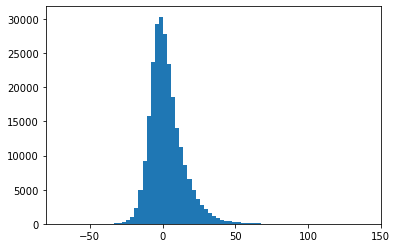

In [141]:
plt.hist(y_pred,bins=100)
#plt.hist(X_train['arr_delay'],bins=300)
plt.xlim(-80,150)

In [15]:
col = ['fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
 'crs_dep_time',  'crs_arr_time',   'distance',     
 'tmpf', 'sknt', 'vsby', 'gust', 'skyl1', 'ice_accretion_3hr',
 'tmpf_arr', 'sknt_arr', 'vsby_arr', 'gust_arr', 'skyl1_arr', 'ice_accretion_3hr_arr']

In [27]:
X_test = df_test[col]

In [28]:
# after test data, arr_delay should be 0. 
X_test['arr_delay'].fillna(0,inplace=True)

#remove outliner
#X_test = X_test[(X_test['arr_delay'] > -80) & (X_test['arr_delay'] < 480)] 

#combine features
def combine_str_num(x,y):
    return x + str(y)
X_test['uni_fl'] = np.vectorize(combine_str_num)(X_test['op_unique_carrier'],X_test['op_carrier_fl_num'])
X_test.drop(columns=['op_unique_carrier','op_carrier_fl_num'],inplace=True)

# feature coding
#unifl_target_mean = X_test.groupby(['uni_fl'])['arr_delay'].mean()
X_test['uni_fl'] =X_test['uni_fl'].map(unifl_target_mean)
X_test['uni_fl'].fillna(total_target_mean,inplace=True)

In [29]:
## Combine the airportid and related hour

    
X_test['arr_airport_hour'] = np.vectorize(airport_hour)(X_test['dest_airport_id'],X_test['crs_arr_time'])
X_test['dep_airport_hour'] = np.vectorize(airport_hour)(X_test['origin_airport_id'],X_test['crs_dep_time'])


# feature coding
#dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_test['dep_airport_hour'] =X_test['dep_airport_hour'].map(dep_hour_target_mean)
#arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_test['arr_airport_hour'] =X_test['arr_airport_hour'].map(arr_hour_target_mean)

X_test['arr_airport_hour'].fillna(total_target_mean,inplace=True)
X_test['dep_airport_hour'].fillna(total_target_mean,inplace=True)

X_test.drop(columns=['dest_airport_id','crs_arr_time','origin_airport_id','crs_dep_time'],inplace=True)

In [30]:

#transform fl_date
#def getmonth(x):
#    return x.split(sep='-')[1]
#X_test['month'] = X_test['fl_date'].apply(getmonth)

#sin_m, cos_m = transformation(X_test['month'].astype('int32'))
#X_test['mon_sin'] = sin_m
#X_test['mon_cos'] = cos_m

def getdayofweek(x):
    year_s, mon_s, day_s = x.split('-')
    fl_d = datetime(int(year_s), int(mon_s), int(day_s))
    return fl_d.weekday() + 1
X_test['day_of_week'] = X_test['fl_date'].apply(getdayofweek)

us_holidays = holidays.UnitedStates()
def isholiday(x):
    year_s, mon_s, day_s = x.split('-')
    if datetime(int(year_s), int(mon_s), int(day_s)) in us_holidays:
        return 1
    else:
        return 0
X_test['is_holiday'] = X_test['fl_date'].apply(isholiday)



pi=3.14159
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

sin_l, cos_l = transformation(X_test['day_of_week'])

X_test['dow_sin'] = sin_l
X_test['dow_cos'] = cos_l



In [31]:
y_test = X_test['arr_delay'].apply(tran_delay)
X_test = X_test.drop(columns=['fl_date','day_of_week','arr_delay'])

#X_test = pd.get_dummies(X_test,columns=['month','day_of_week'])

#X_test = scaler.transform(X_test)

In [34]:
X_test = scaler.transform(X_test)

In [32]:
X_test.shape

(29411, 19)

In [33]:
y_test.shape

(29411,)

## Build and train Deep Learning Network

In [ ]:
network = Sequential()
network.add(Dense(128,  input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
network.add(Dense(64, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(5, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [328]:
# define the  model
def build_model():
  model = Sequential()
  model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile the keras model
  # opt = tf.keras.optimizers.Adam(clipnorm=1, learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [1]:
import pickle

In [51]:
pickle.dump(model,open('final_model.sav','wb'))

In [39]:
load_model = pickle.load(open('final_model.sav','rb'))

In [41]:
y_pred = load_model.predict(dtest)

In [49]:
np.mean(y_pred)

-0.6838302

In [48]:
r2_score(y_test,y_pred)

-0.08041162600054985